# **Utilización, procesamiento y visualización de grandes volúmenes de datos**
---

## **Inteligencia artificial avanzada para la ciencia de datos**

### **Momento de Retroalimentación**

---

**Alumno:** Diego Lira García -A01710369

**Profesor:** Dr. Ismael Solis Moreno  

**Fecha de entrega:** 4/11/2025

---


# Introduccion

En este jupyter notebook se encuntra un reporte con el codigo usado para la creacion de un modelo de regresión. El modelo predice el costo total que se deberia cobrar en un viaje en taxi en NYC entre las fehca de enero a marzo del 2016 con una precición de R2: 89%.

El dataset proviene del usuario elemento en la plataforma de kaggle. El cual ya fue transformada para solo tener la información necesaria para la predicción del viaje.

Se utilizó *Tableau* para graficar los datos y comprenderlos de mejor manera para la toma de decisiones sobre su utilidad y veracidad.

# Configuración del entorno para usar PySpark

##Actualizaciones y descarga de paquetes

In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.6/spark-3.5.6-bin-hadoop3.tgz
!tar xf spark-3.5.6-bin-hadoop3.tgz

Se descargó OpenJDK, que es la version 8 abierta de Jave Development Kit. Es necesario tener Java para que PySpark pueda funcionar. También se descargó el archivo comprimido de Apache Spark, version 3.5.6 (es la version que me funcionó mejor). Para luego instararlo y que el jupyter notebook pueda acceder a los archivos de PySpark

## Instalación de librerias

In [ ]:
!pip install -q findspark
!pip install pyspark

Se intstaló la PySpark y FindSpark.
PySpark es la API que estaremos usando para acceder a clases y sus funcione.
FindSpark es lo para que encuentre donde esta Spark

## Variables de Entorno

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.6-bin-hadoop3"


Se crearón estas variables para hacer referencia a donde esta guardado en el jupyter notebook Java y Spark

## Instalación de Spark

In [ ]:
import findspark
findspark.init()
findspark.find()

Usando la variable SPARK_HOME, la función .init() permite poder iniciar la sesión de Spark para usar en este trabajo.
.find() regresó el path donde encontró y configuró todo. Por eso es la misma que SPARK_HOME. Sirve para confirmar que se configuró en el lugar correcto.

## Creando la sesión de Spark

In [ ]:
from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F
import pyspark.sql.window as W
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator


spark = SparkSession \
       .builder \
       .appName("Utilización, procesamiento y visualización de grandes volúmenes de datos") \
       .getOrCreate()

spark

Se instalarón librerías para poder crear una sesión de Spark, usar DataFrames, definir los tipos de variables y SQL.

Se creó una variable que guarde la sesión de Spark llamada "spark"

# Dataset

## Descarga del Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("elemento/nyc-yellow-taxi-trip-data")

print("Path to dataset files:", path)

El código que se usó para descargar proviene de kaggle.

## Acerca del Dataset

El dataset proviene del siguinete enlace: [kaggle-dataset](https://www.kaggle.com/datasets/elemento/nyc-yellow-taxi-trip-data)

Agradecimiento al usuario, elemento, por publicar este dataset de forma publica.

El dataset que se usó para este reporte tiene la información de los viajes que se realizarón en la ciudad de Nueva York en el mes de enero del 2015 y de enero a marzo del 2016. La informacion proviene de la pagina de Taxi & Limousine Commission (TLC), la cual es gratis de descargar desde este [enlace](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

El dataset ya fue limpiado para que los datos presentes fueran unicmante de los taxis amarillos de la ciudad de Nueva York.

## Carga del Dataset

In [ ]:
df = spark.read.csv(path, header=True)

In [ ]:
#df.show()

El dataset cuenta con las siguientes columnas:


*   VendorID - Codigo para indicar de que provedor viene la información
*   tpep_pickup_datetime - Fecha y tiempo de cuando inició el taxímetro
*   tpep_dropoff_datetime - Fecha y tiempo de cuando se detuvó el taxímetro
*   Passenger_count - Numero de pasajeros
*   Trip_distance - Millas que duró el viaje
*   Pickup_longitude - Longitud cuando el taxímetro inició
*   Pickup_latitude - Latitud cuando el taxímetro inició
*   RateCodeID - Código usado para indentificar la estructura de la tarifa
*   Store_and_fwd_flag - Indentificador para saber si el viaje se guardo en la memoria del vehículo antes de ser mandado
*   Dropoff_longitude - Longitud cuando el taxímetro terminó
*   Dropff_latitude - Latitud cuando el taxímetro terminó
*   Payment_type - Código para indentificar el tipo de pago
*   Fare_amount - La tarifa calculadá por el taxímetro
*   Extra - Cobros extras
*   MTA_tax - Impuesto por operar bajo el Distrito Metropolitano de Transporte de Pasajeros (MCTD)
*   Improvement_surcharge - Comisión para mejorar el transporte
*   Tip_amount - Propina solo incluida con tarjeta de credito
*   Tolls_amount - El total de los peajes pagados durante el viaje
*   Total_amount - El importe total cobrado a los pasajeros. No incluye propinas en efectivo

## Transformación del Dataset.

### Checando por nulos

In [ ]:
null_counts = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+--------+--------------------+---------------------+---------------+-------------+----------------+---------------+----------+------------------+-----------------+----------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|pickup_longitude|pickup_latitude|RatecodeID|store_and_fwd_flag|dropoff_longitude|dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+----------------+---------------+----------+------------------+-----------------+----------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       0|                   0|                    0|              0|            0|               0|              0|         0|                 0|              

In [ ]:
df = df.dropna().dropDuplicates()

Se encontró que la unica columna que contenia nulos era improvement_surcharge. Como solo era tres nulos se decidío eliminar esas 3 instancías, en lugar de imputarle valores. Al ser pocos nulos podemos eliminarlos sin miedo a perder información importante para el entrenamiento de nuestro modelo.

### Eliminación de Columnas

In [ ]:
df_clean = df.drop(*["VendorID","store_and_fwd_flag",
                    "pickup_longitude","pickup_latitude",
                    "dropoff_longitude","dropoff_latitude",
                    "fare_amount", "extra",
                    "mta_tax", "tip_amount","tolls_amount",
                    "improvement_surcharge"])

In [ ]:
#df_clean.show()

Se decidió eliminar las columnas por las siguente razones:

* Vendor ID: No aporta valor para la predicción, ya que solo es un ID de que provedor viene la info del viaje.
* Store_and_fwd_flag: No aporta valor para la predicción, solo muestra si la información se guardó antes de mandarse o no.
* pickup longitude-latitude y dropoff longitud-latitude: Se usarían para calcular la distacia del viaje, pero ya hay una columna que guarda.
* fare_amount, extra","mta_tax, tip_amount,tolls_amount y improvement_surcharge: Todas estas columnas son los valores que se suman para el total del viaje. Para evitar que el modelo "aprenda" a sumar estos valores, se eliminaron de su entrenamiento.


Columnas que se considerón mantenerse aunque no aporten valor:

* payment_type: Aunque no afecte la tafira en metodo de pago que uses. Se consideró que seria interesante ver las formas de pago de los viajes en taxi en NYC



### Seperación de columnas y one hot encoding

In [ ]:
df_one = df_clean.withColumn("day_pickup", F.day(F.col("tpep_pickup_datetime")))
df_one = df_one.withColumn("month_pickup", F.month(F.col("tpep_pickup_datetime")))
df_one = df_one.withColumn("year_pickup", F.year(F.col("tpep_pickup_datetime")))
df_one = df_one.withColumn("day_dropoff", F.day(F.col("tpep_dropoff_datetime")))
df_one = df_one.withColumn("month_dropoff", F.month(F.col("tpep_dropoff_datetime")))
df_one = df_one.withColumn("year_dropoff", F.year(F.col("tpep_dropoff_datetime")))
#df_one.show()

Se separaró la columna de la fehca en año, mes y día. De esa forma tenemos un mejor control para entrenar el modelo y podemos asegurnos de que no hay un dato que este fuera de las que da el dataset.

In [ ]:
df_time = df_one.withColumn("time_pickup", F.date_format("tpep_pickup_datetime", "HH:mm:ss"))
df_time = df_time.withColumn("time_dropoff", F.date_format("tpep_dropoff_datetime", "HH:mm:ss"))
#df_time.show()

Se separó también las horas de inicio y fin del viaje.

In [ ]:
df_pay = df_time.withColumn("payment_type", F.when(F.col("payment_type") == 1, "Credit card")
                                             .when(F.col("payment_type") == 2, "Cash")
                                             .when(F.col("payment_type") == 3, "No charge")
                                             .when(F.col("payment_type") == 4, "Dispute")
                                             .when(F.col("payment_type") == 5, "Unknown")
                                             .when(F.col("payment_type") == 6, "Voided trip")
                                             .otherwise("Unknown"))
df_rate = df_pay.withColumn("RatecodeID", F.when(F.col("Ratecodeid") == 1, "Standard rate")
                                          .when(F.col("Ratecodeid") == 2, "JFK")
                                          .when(F.col("Ratecodeid") == 3, "Newark")
                                          .when(F.col("Ratecodeid") == 4, "Nassau or Westchester")
                                          .when(F.col("Ratecodeid") == 5, "Negotiated fare")
                                          .when(F.col("Ratecodeid") == 6, "Group ride")
                                          .otherwise("Unkown"))
#df_rate.show()

Se pasarón sus valores numericos a cadenas de texto, para que sea más fácil su interpretación. Dejamos la columna de pickup y dropoff originales, para que en tableau sea más facil vizualisar los tiempos, pero a la hora de trabajar entrenando el modelo sea más fácil.

### Eliminar filas de años no correctos.

In [ ]:
df_ready = df_rate.filter((F.col("year_pickup") == 2016))
#df_ready.show()

## Exportación del dataset

In [ ]:
#df_rate.coalesce(1).write.csv("Taxi_NYC.csv")

### Eliminar filas y columnas

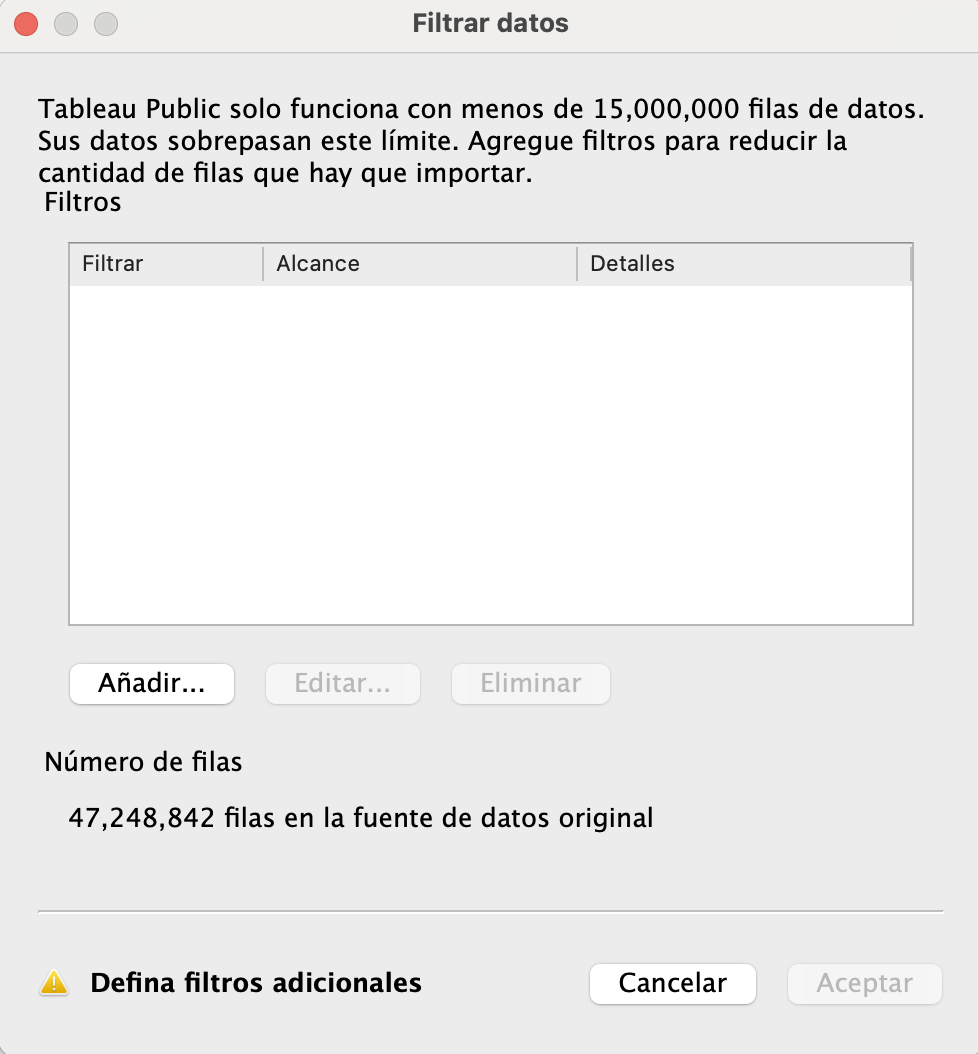

Se tuvó que eliminar filas poder usar Tableau Public, ya que tiene un limite de 15 millones y mi dataset tenía 47 millones.

In [ ]:
window_order = W.Window.orderBy("tpep_pickup_datetime")
df_seq = df_rate.withColumn("id", F.row_number().over(window_order))
df_cut = df_seq.filter(F.col("id") % 6 == 0)

Para cortar el dataset he intentar mantener la mayor información posible de todas las fechas. Lo que se realizó fue orderner de acuerdo a la feche y hora de inicio del viaje, para luego ir seleccionando una fila cada 6. Esto es debido a las limitaciones de mi laptop que se queda sin memoria a la hora de intentar procesar ese archivo pero que todovia tuviera un minimo de un 1GB de datos

In [ ]:
#df_cut.coalesce(1).write.csv("Taxi_NYC.csv", header=True, mode="overwrite")

# Tableau

Se puede encontrar el tableu public en el siguiente [enlace](https://public.tableau.com/app/profile/diego.lira1935/viz/DiegoLiraGarca_Modulo/Historia1?publish=yes)

Se utilizó Tableau para vizualiar los datos y aplicarles filtros. De esa forma se econtrarón patrones y se decidió agregar o eliminar columnas.

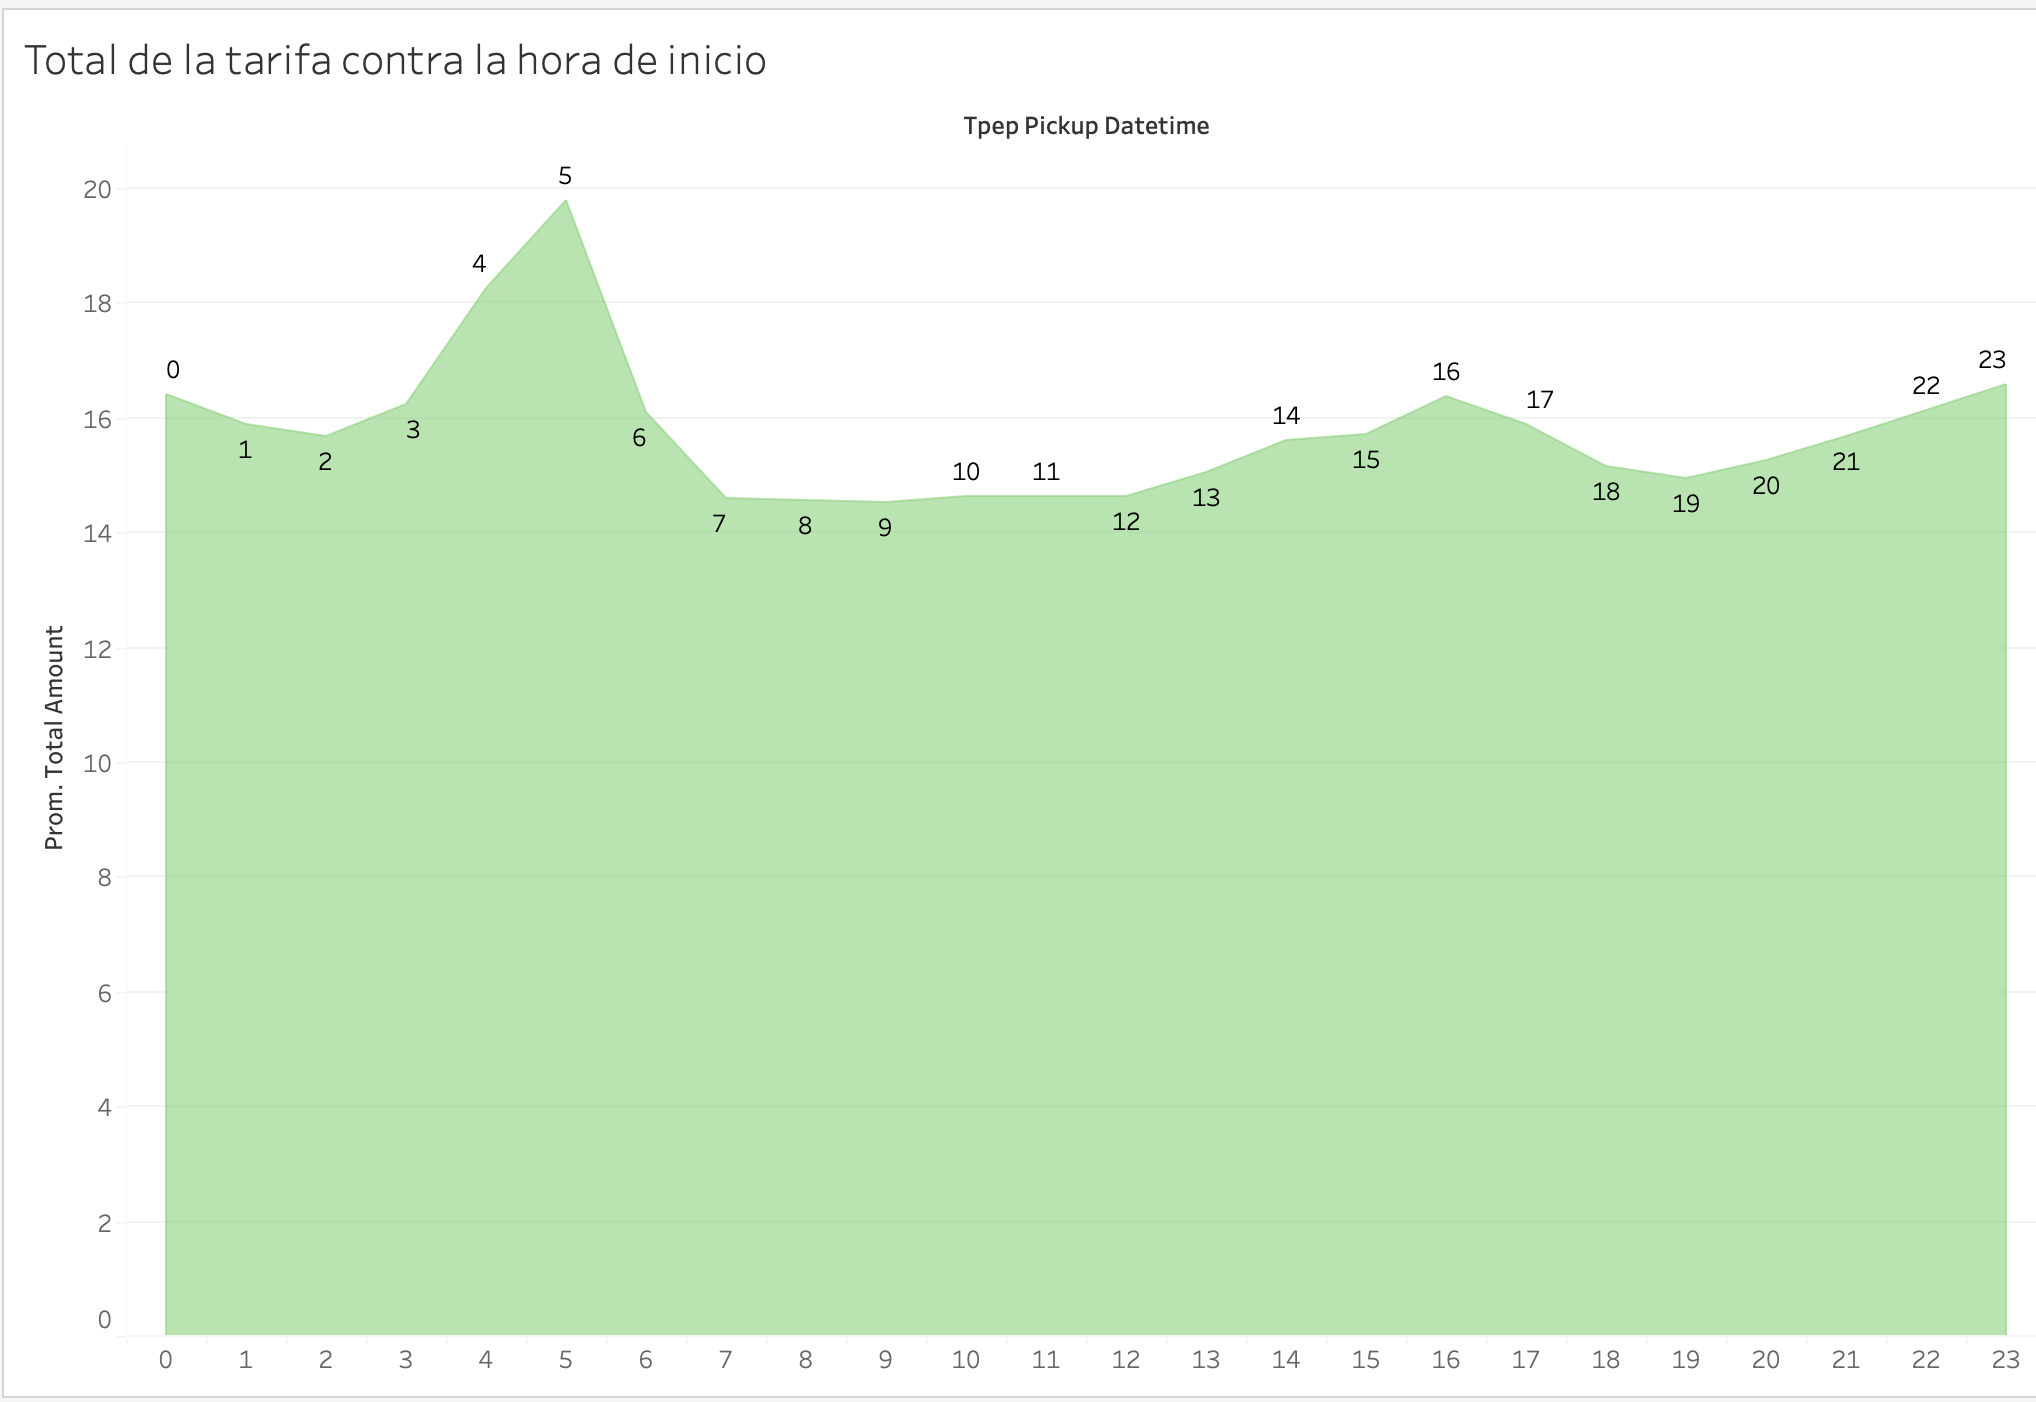

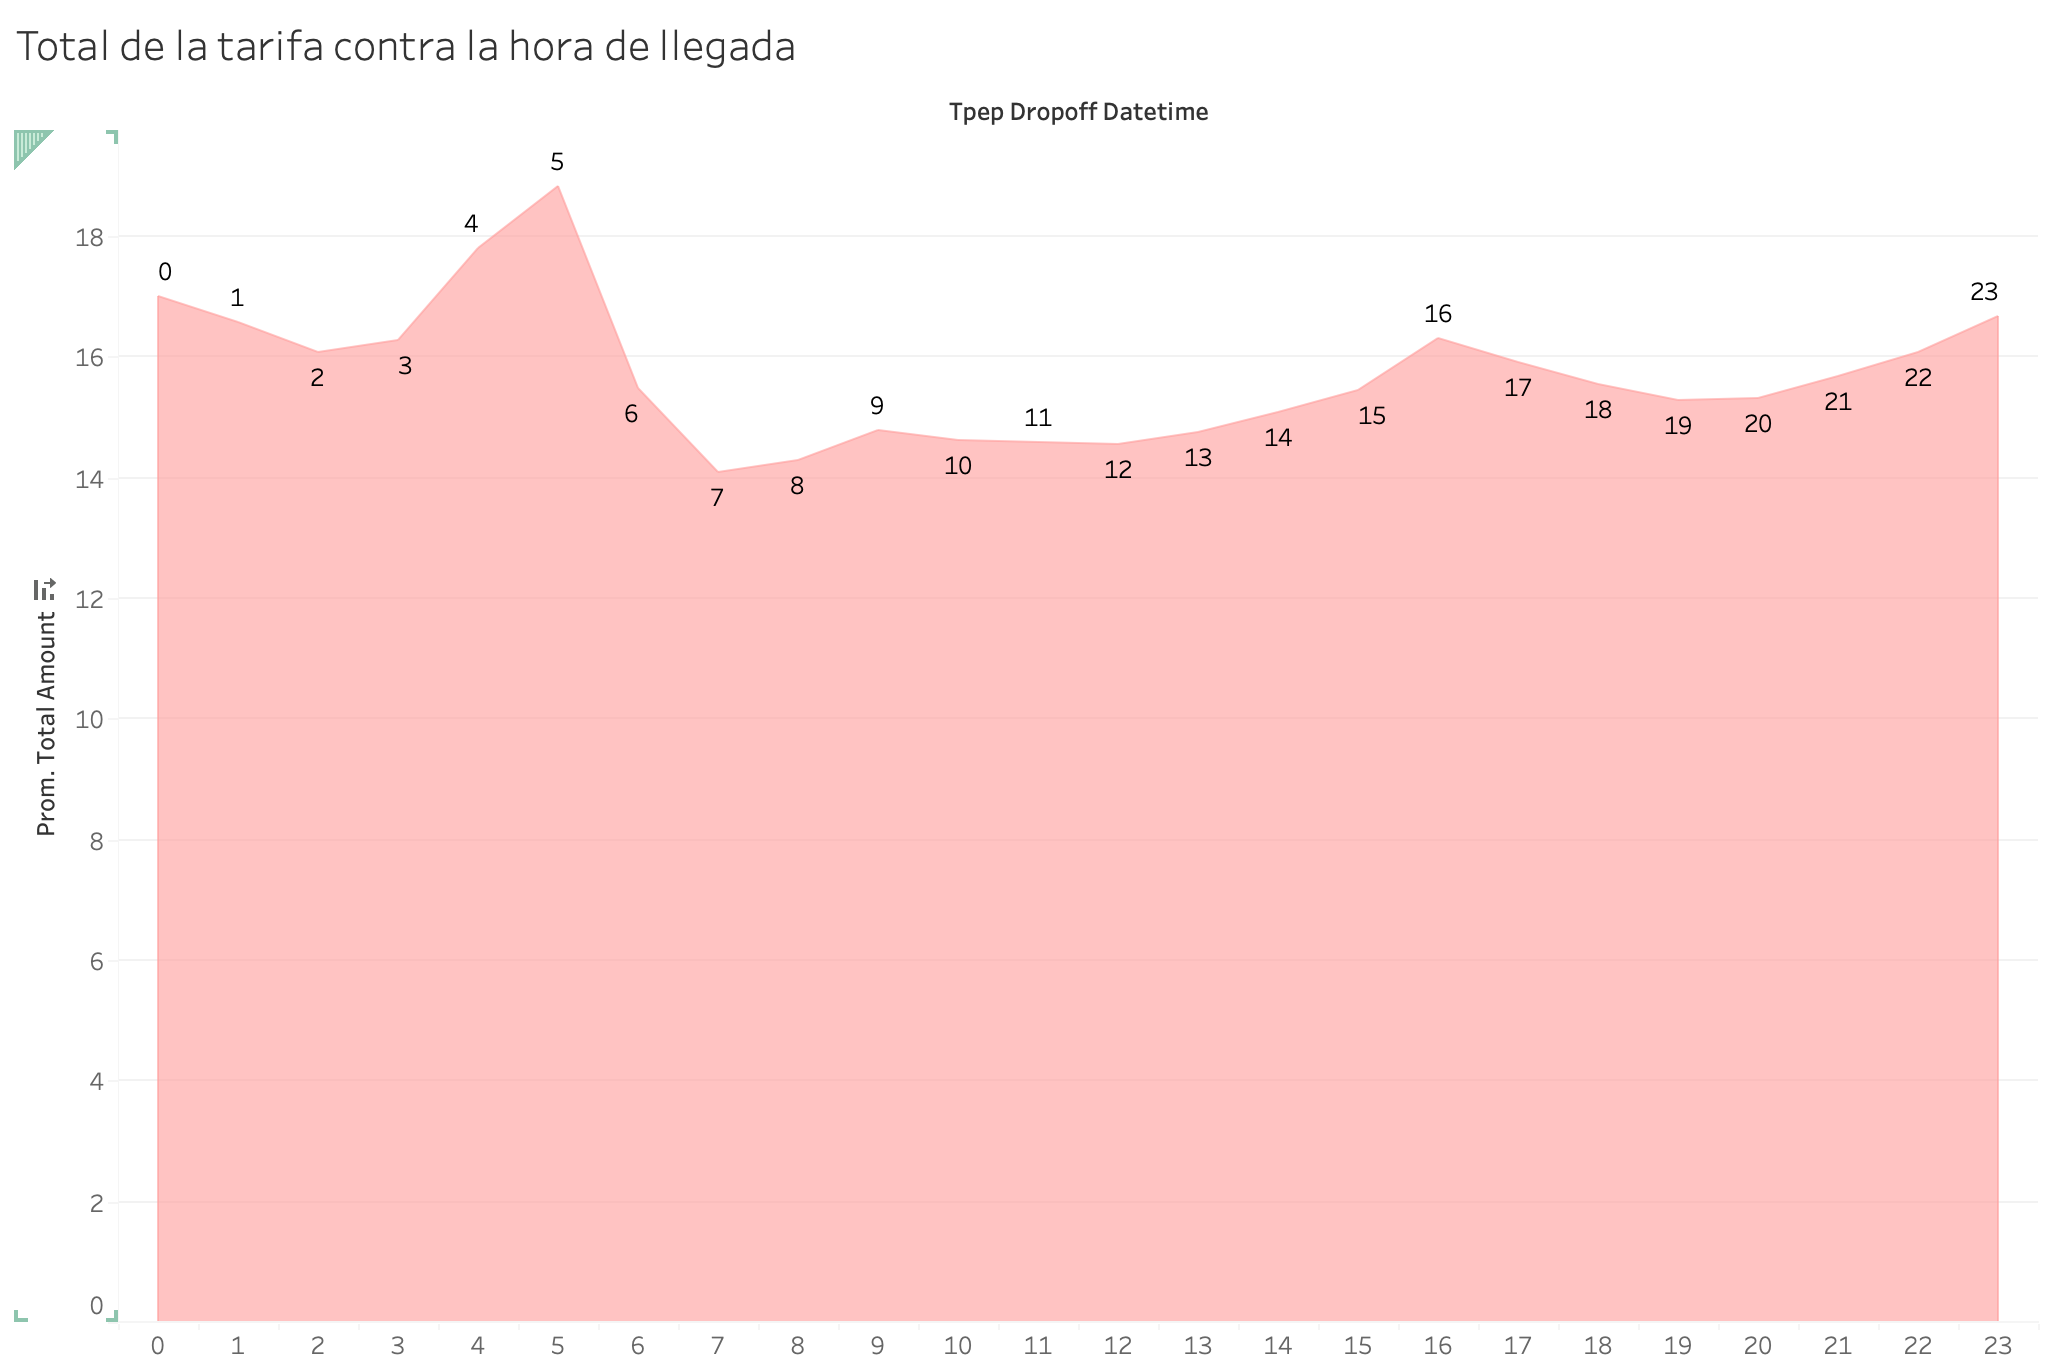

Tanto para la hora de inicio como terminar se observó que hay horas que en promedio sale más caro que otras horas. Por eso se decidió edtiar las columnas de pickup y dropoff para que solo guardarán la hora y no todo el tiempo.



In [ ]:
df_hr = df_cut.withColumn("pickup_hour", F.hour(F.col("tpep_pickup_datetime"))).withColumn("dropoff_hour", F.hour(F.col("tpep_dropoff_datetime")))
df_hr.drop("time_pickup").drop("time_dropoff")

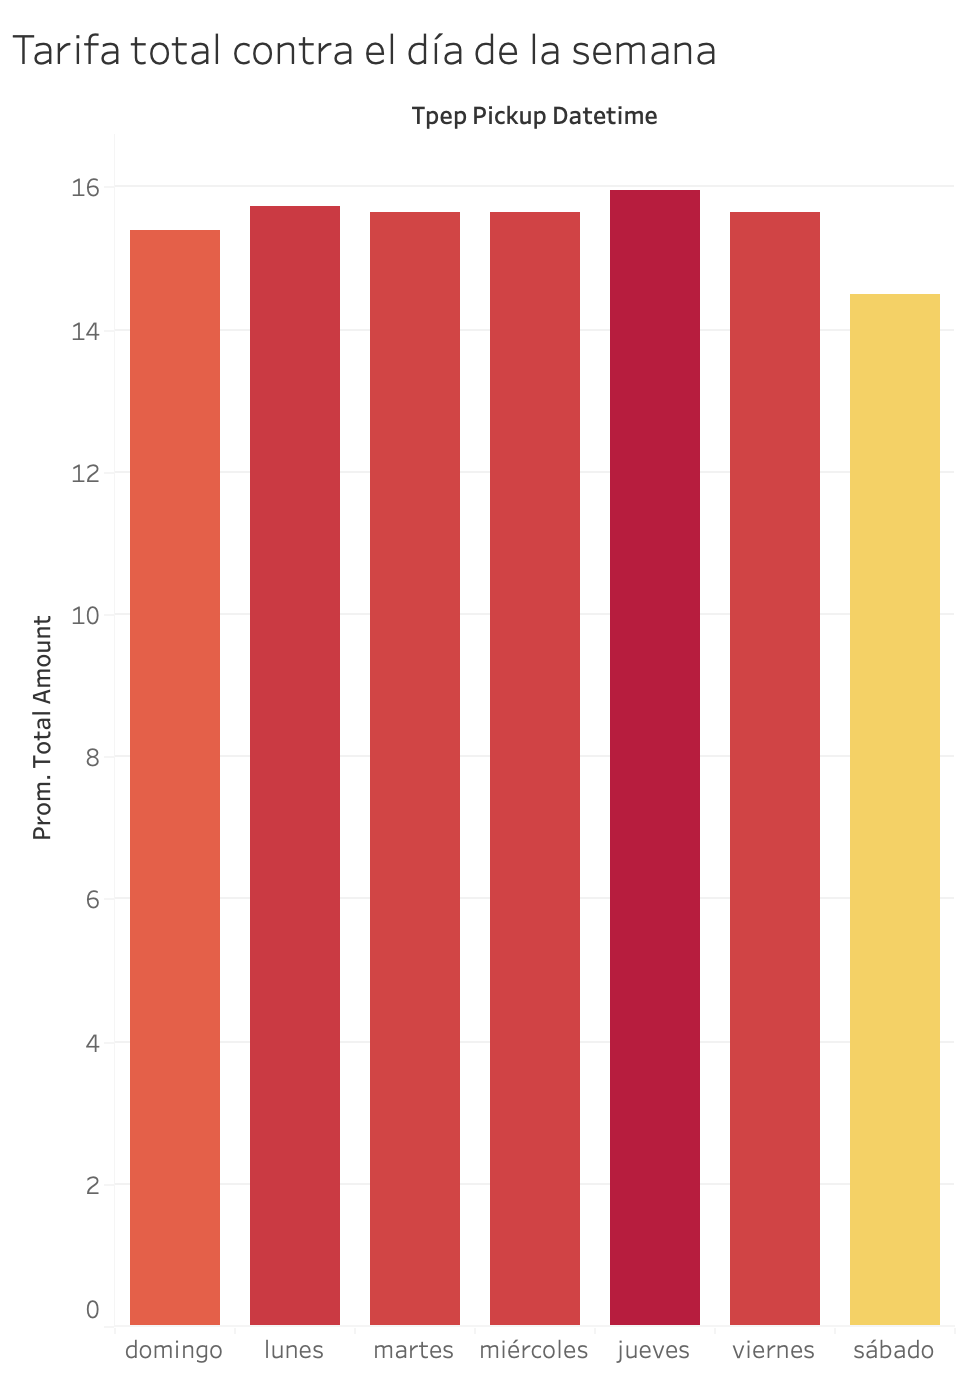

Al ver los días de la semana se vió que en promedio cuestan lo mismo, a excepcion del sabado que suele ser más barato. Es por eso que se decidió hacer una variable categorica para los días de la semana para tener en cuenta este factor que no se había previsto.

In [ ]:
df_day = df_hr.withColumn("day_of_week", F.dayofweek(F.col("tpep_pickup_datetime")))
#df_day.show()

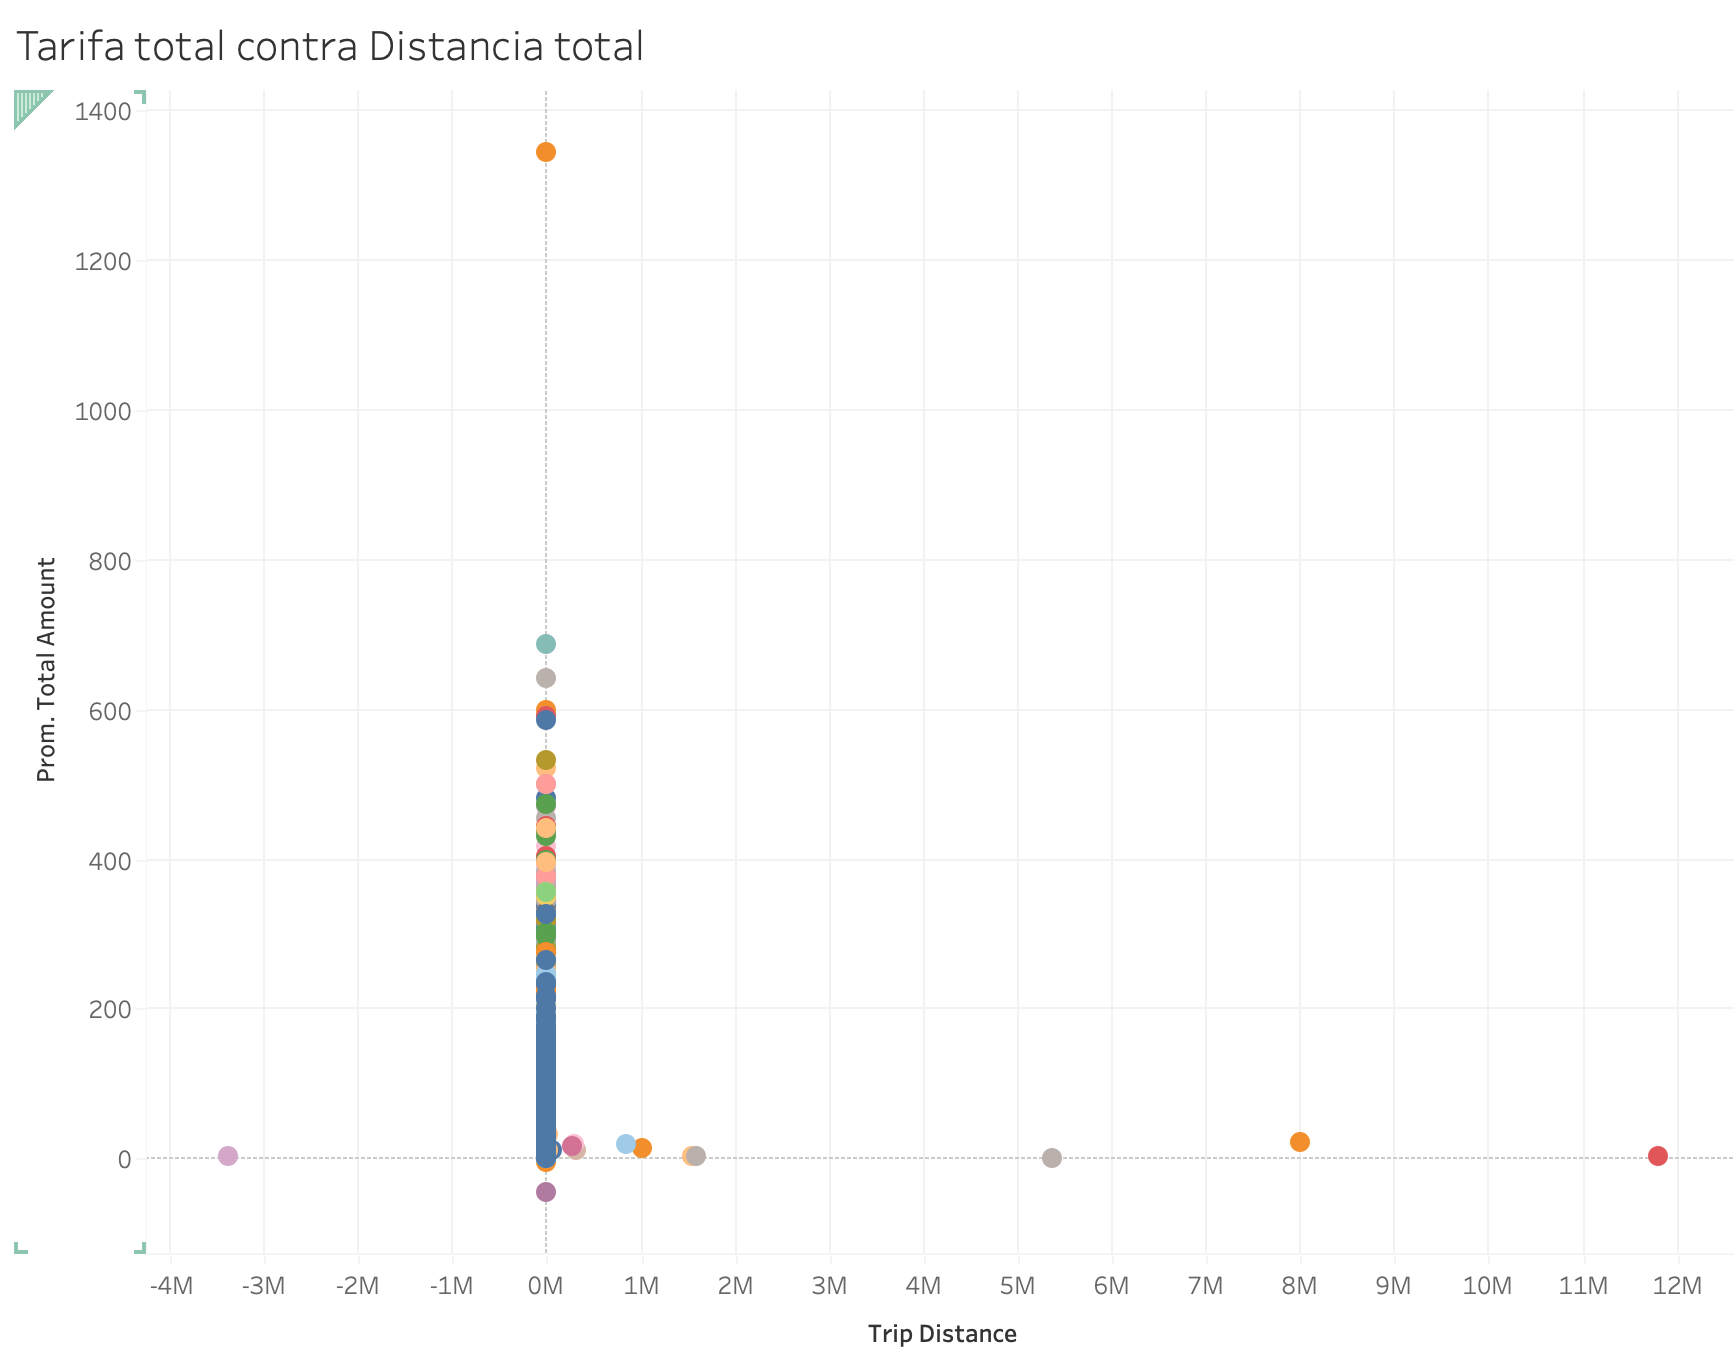

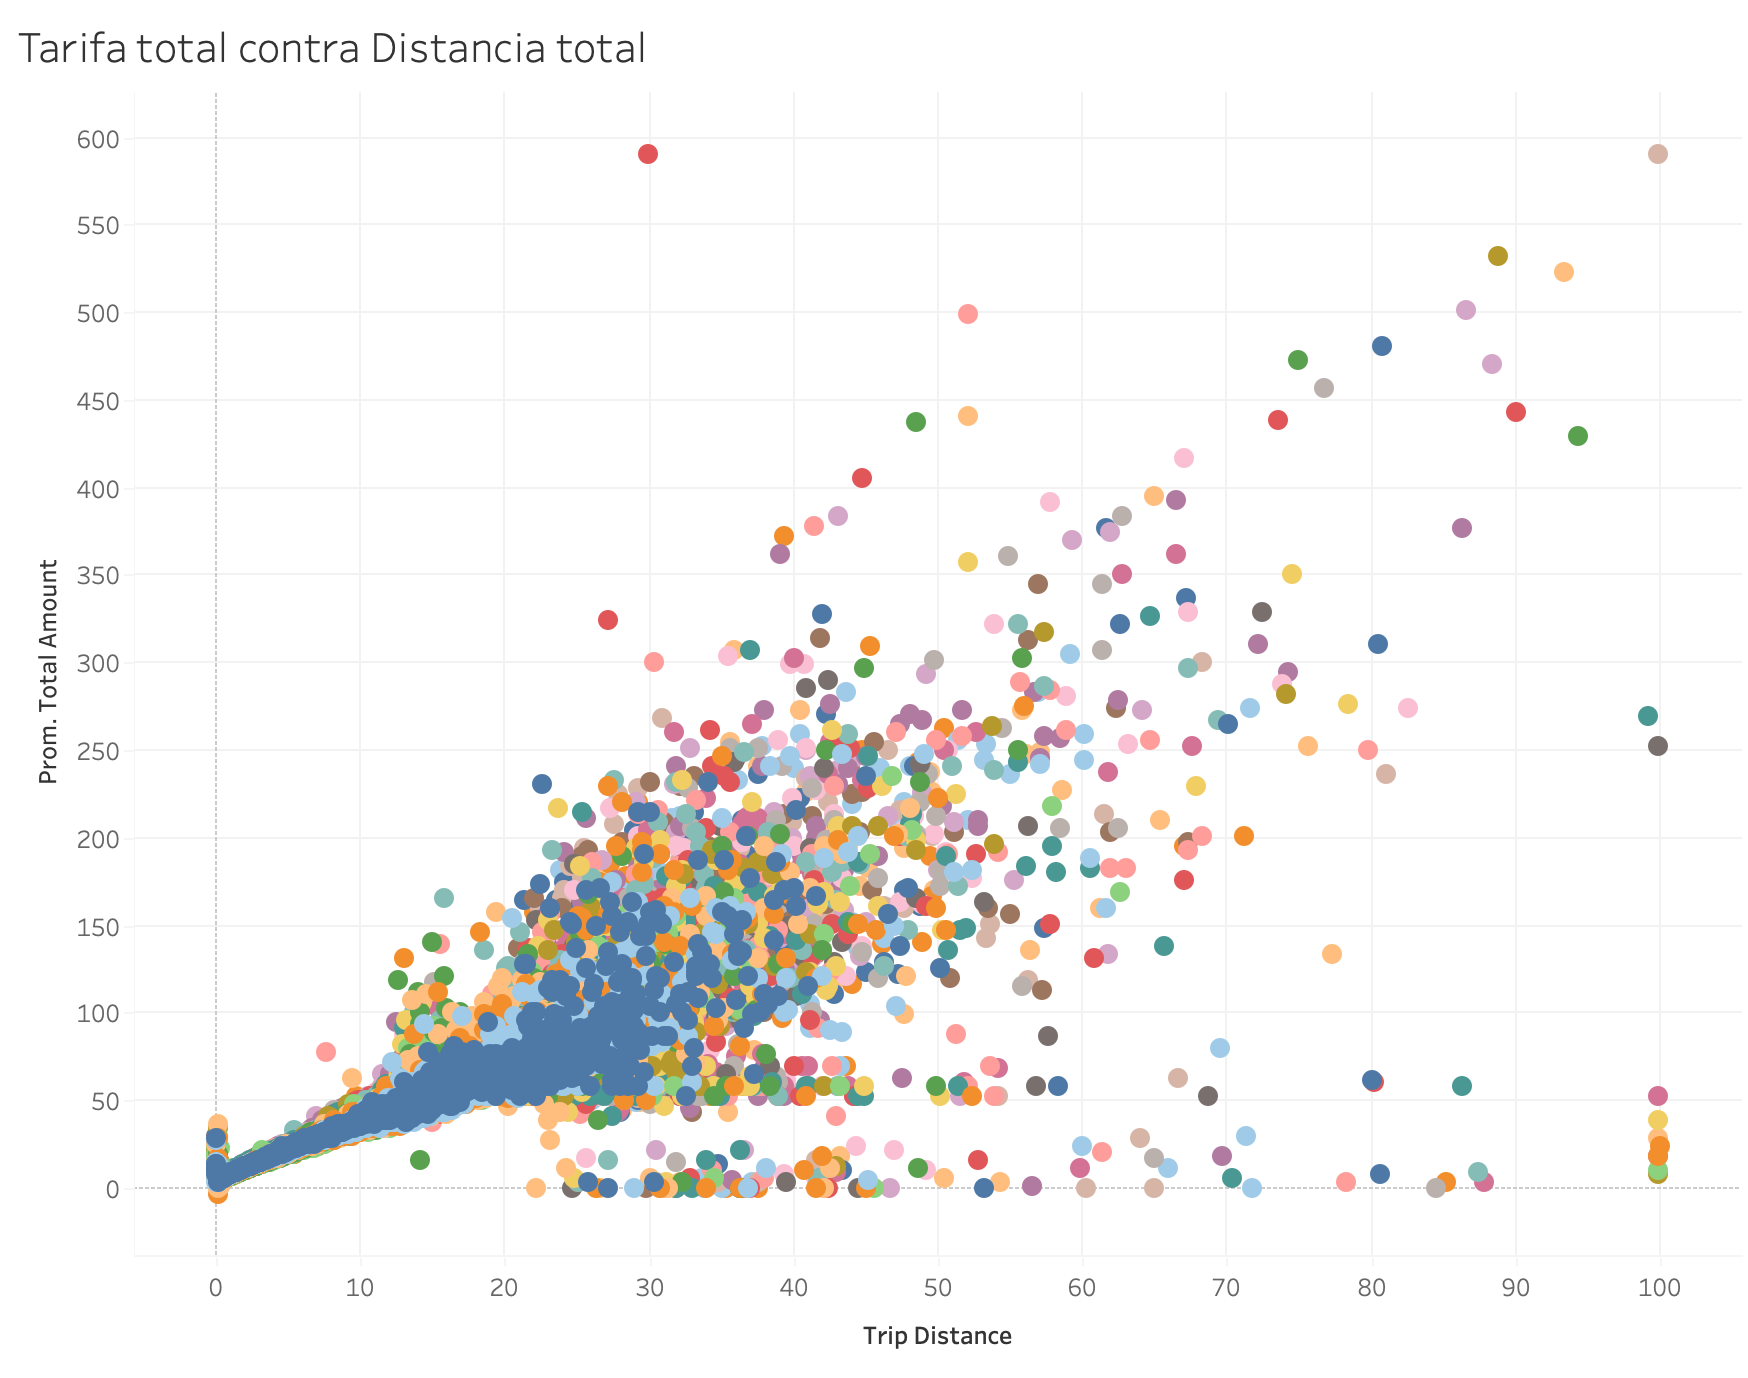

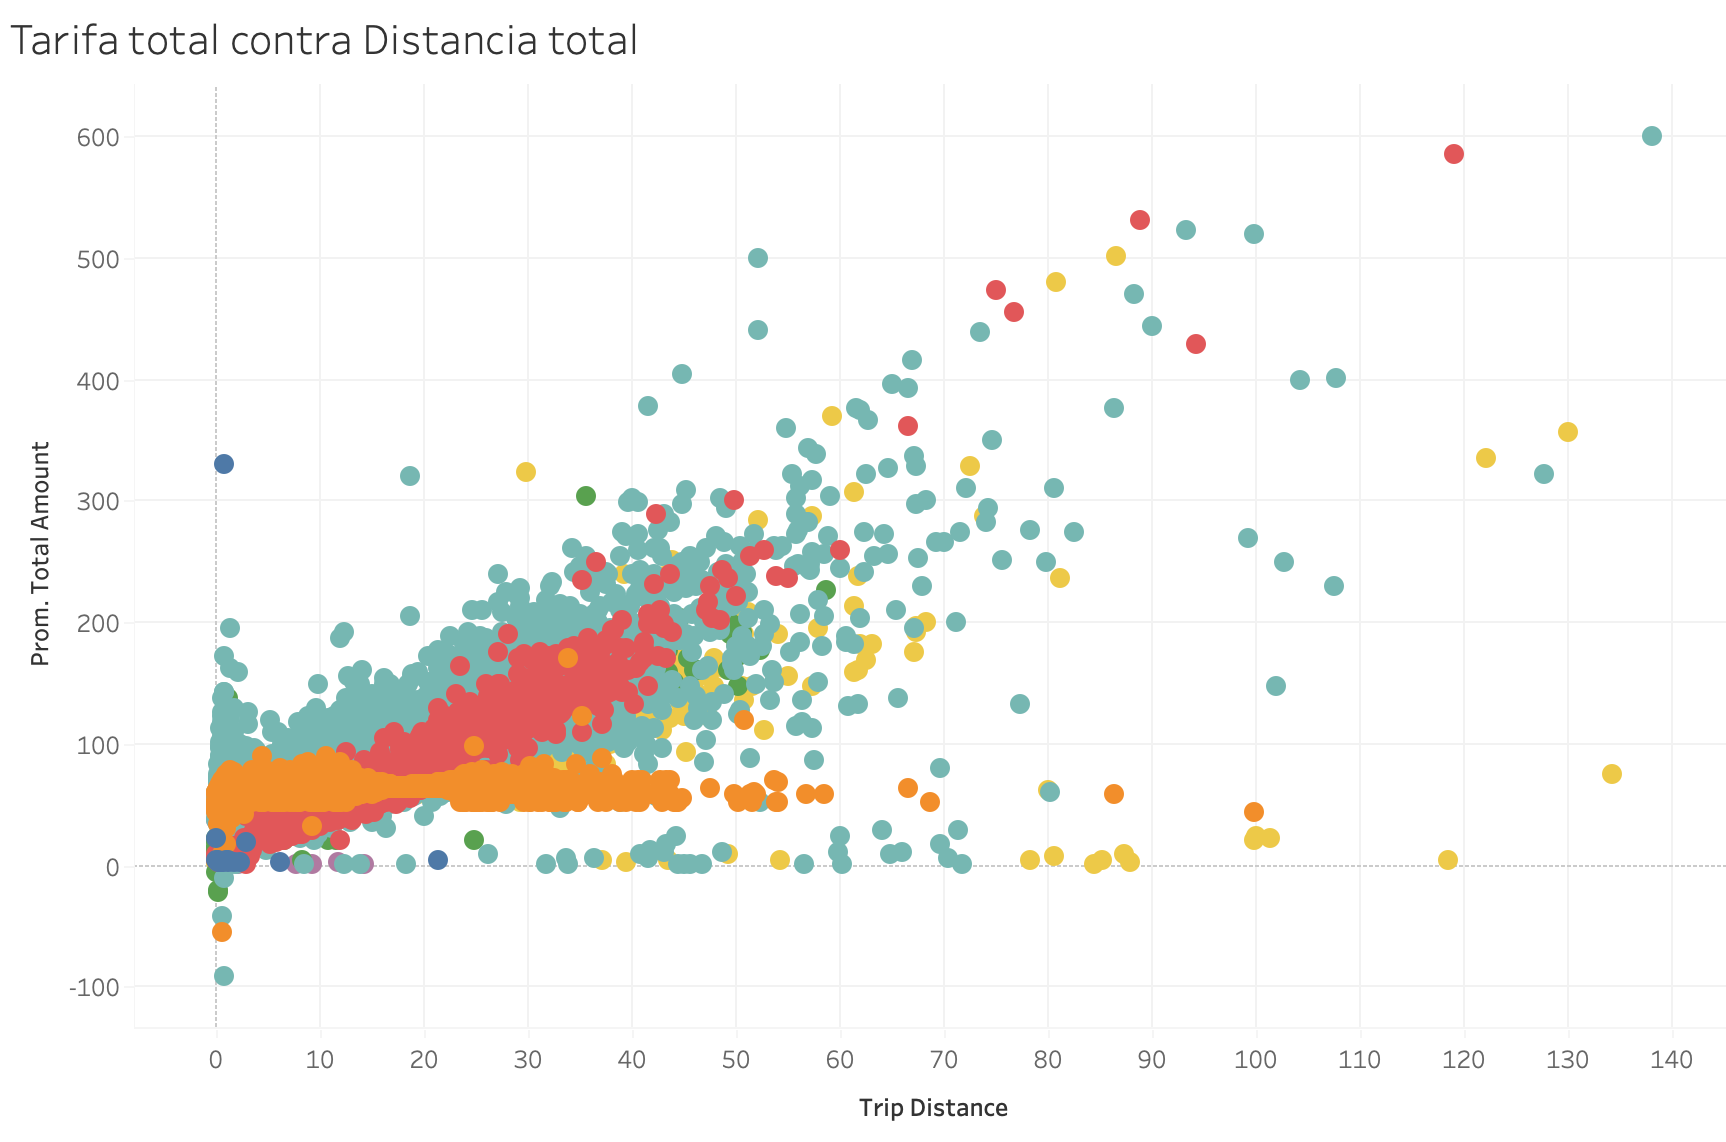

En la primera imagen se observó que habia valores negativos y valor muy atipicos como viajes de 120 millas y que cuesta menos en promedio que uno de 60 millas. Se tuvó que eliminar los datos negatvios. Viendo estos datos que y los anteriores. Se decidio que el mejor modelo para este dataset es random forrest regressor. Estos datos aunque al inicio se muestran lineales, despues pierden esa linealidad además de que el random forrest es más robusto y no se ve tan afectado con los valores atipicos que hay en este dataset. Con respecto a las demás graficas tampoco se observa una distribución normal. Cuando se observó la la tercera grafica, se vio que la mayoria de los datos que estan con precios muy bajos para la distacia pertenencen al grupo de tarifas negociadas (el grupo azul-verde) puede darse a entender que dirieron una tarifa muy pequeña para evitar pagar impuesto, y el resto lo recibieron en propinas en efectivos, que son las que no hay registro en dataset original. Pero a falta de pruebas de esa hipotesis se decidio conservar esos datos. Solo elinaremos los negativos.

In [ ]:
df_neg = df_day.filter(df_day.trip_distance > 0)

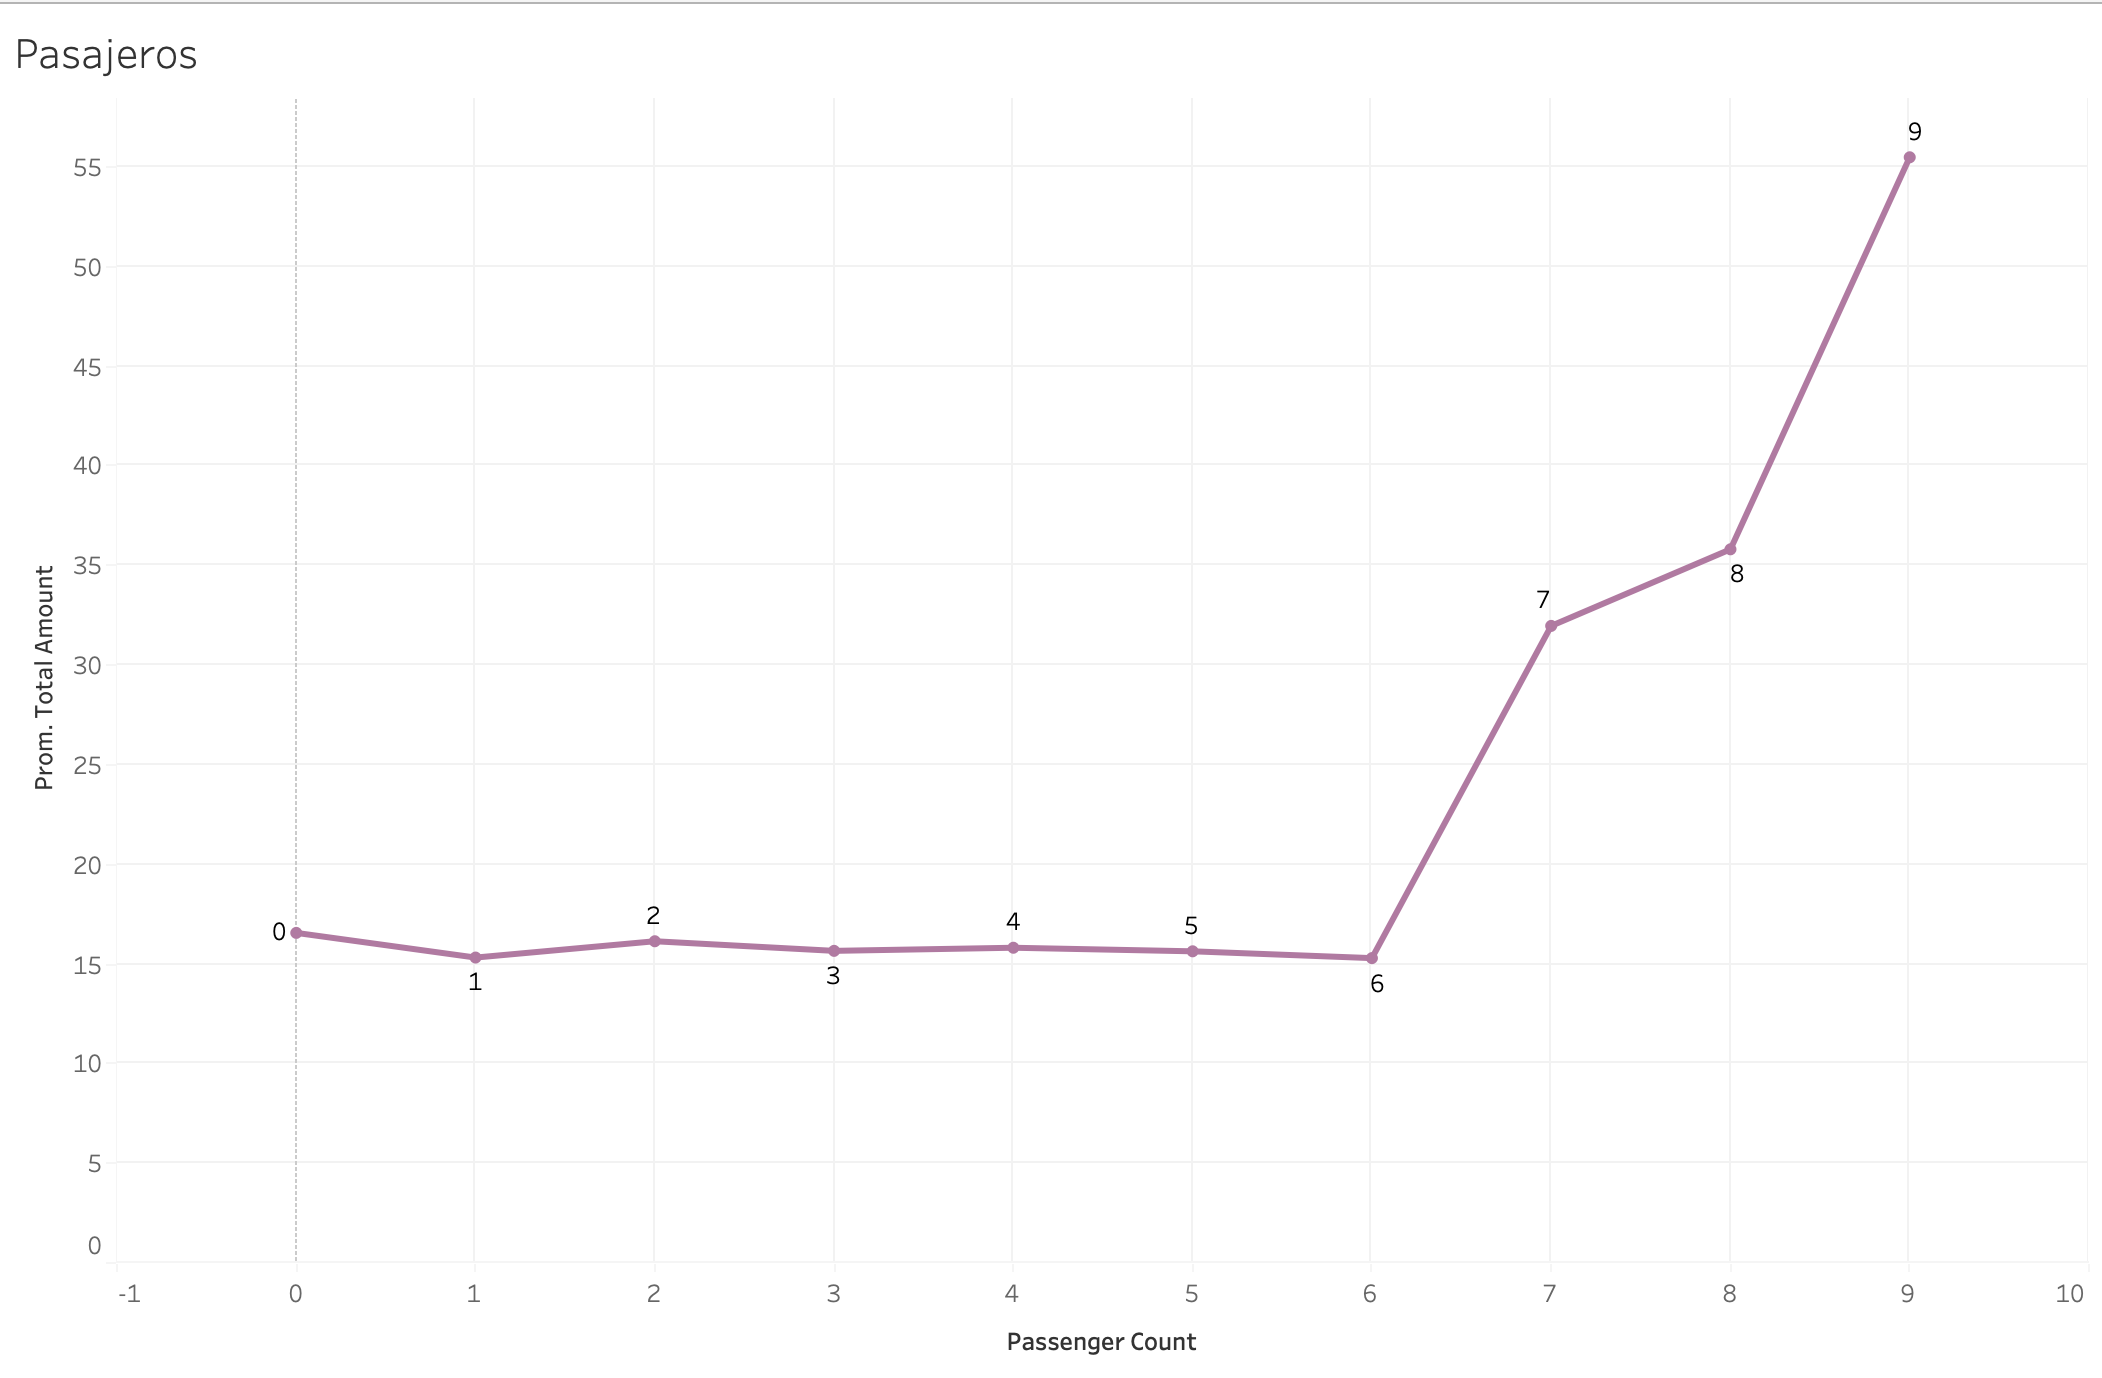

Se conservó la columna de pasajeros al ver que el número de pasajeros afecta el costo final de la tarifa. Aunque este fenomeno solo se presenta apartir de 7 o más.

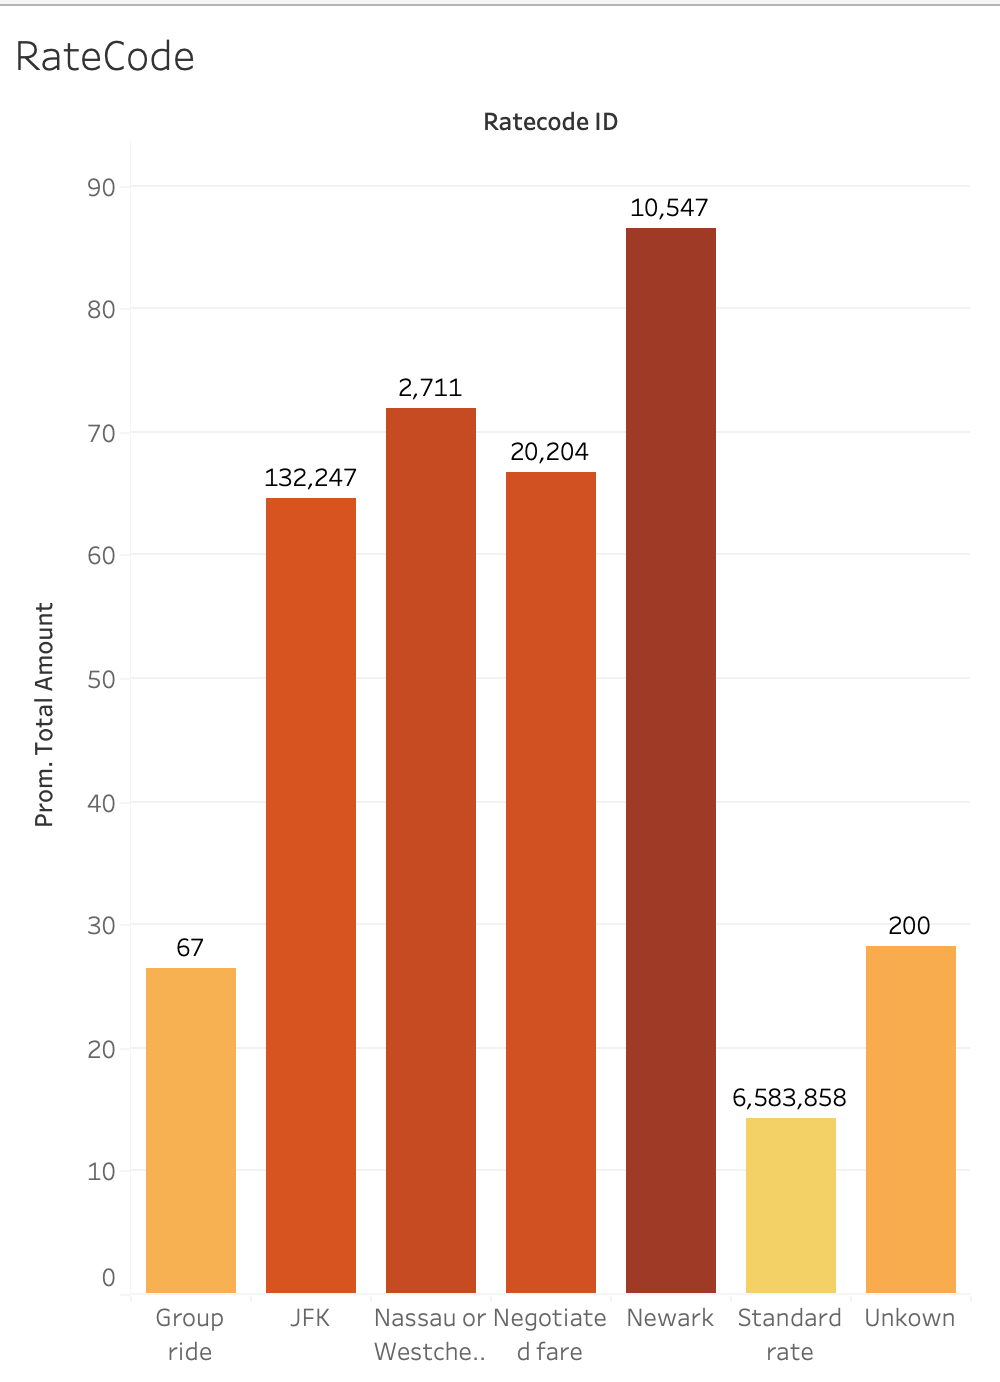

Finalmente vemos que la tasa del viaje es crucial para poder predecir el costo. Vemos que aunque Standard rate es que más viajes tuvo tambien es el más barato en promedio.

# Modelo

## Elección de caracteristicas

In [ ]:
columnas = ["passenger_count", "trip_distance", "RatecodeID", "total_amount", "pickup_hour", "day_of_week"]

Se seleccionarón las columnas: passenger_count, trip_distance, RatecodeID, total_amount, pickup_hour, day_of_week.

Por los motivos antes dichos.

In [ ]:
df_feat = df_neg.select(columnas)

In [ ]:
indexer = StringIndexer(inputCol="RatecodeID", outputCol="RateOneHot")
indexerModel = indexer.fit(df_feat)
indexed_df = indexerModel.transform(df_feat)

In [ ]:
data_df = indexed_df.withColumn("trip_distance", indexed_df["trip_distance"].cast(T.FloatType()))
data_df = data_df.withColumn("total_amount", data_df["total_amount"].cast(T.FloatType()))
data_df = data_df.withColumn("passenger_count", data_df["passenger_count"].cast(T.IntegerType()))

Se tuvo que pasaran la variable categorica de RatecodeID a enteros para que funcione con el random forest regressor. Tambien se pasarón a flotante las variables de la distancia el total de la tarifa.

In [ ]:
feature_cols = ["passenger_count", "trip_distance", "RateOneHot", "total_amount", "pickup_hour", "day_of_week"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(data_df)

df_final = data.select("total_amount", "features")

## Toma de decisiones sobre el dataset

## Separación de la data (Train/Validation/Test)

In [ ]:
train, validation, test = df_final.randomSplit(weights=[0.7,0.15,0.15], seed=42)

El 70% de los datos se usarón para entrenar el modelo, 15 % para la validación y dl 15% restante para el test del modelo. Se optó por este enfoque ya que solo tener train y test sin validation, puede hacer que ajustemos los parametros para pasar test y que no tengamos depues forma de evaluar el modelo.

## Random Forest Regressor

In [ ]:
rf = RandomForestRegressor(featuresCol="features", labelCol="total_amount")
rf_model = rf.fit(train)

Dada la naturaleza de los datos se optó por usar un random forest regressor en lugar de una regresion lienal multiple. Al ver los datos en tableu se vio que no todas las caracteristicas pueden ser explicadas con una regresión lineal y es mejor usar un modelo que no se vea afectado por outliers y la falta de una distribución lineal.

El modelo tiene por defecto 20 arboles con profundidad de 5. Para más detalles sobre el modelo por defecto se puede consultar la [documentación](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.RandomForestRegressor.html)

In [ ]:
rf_pred = rf_model.transform(validation)

In [ ]:
evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction")

rmse = evaluator.evaluate(rf_pred, {evaluator.metricName: "rmse"})
print("RMSE: %.3f" % rmse)

mse = evaluator.evaluate(rf_pred, {evaluator.metricName: "mse"})
print("MSE: %.3f" % mse)

mae = evaluator.evaluate(rf_pred, {evaluator.metricName: "mae"})
print("MAE: %.3f" % mae)

r2 = evaluator.evaluate(rf_pred, {evaluator.metricName: "r2"})
print("r2: %.3f" % r2)

Se observó que el modelo puede explicar el 90% de los datos de validation. No es necesario cambiar los parametros actualmente. Se espera que test tenga resultados similares y que no muestre señales de overfitting.

# Predicciones

## Creación de predicciones

In [ ]:
rf_pred_test = rf_model.transform(test)

In [ ]:
pred_df = rf_pred_test.select("total_amount", "prediction")

In [ ]:
evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction")

rmse = evaluator.evaluate(pred_df, {evaluator.metricName: "rmse"})
print("RMSE: %.3f" % rmse)

mse = evaluator.evaluate(pred_df, {evaluator.metricName: "mse"})
print("MSE: %.3f" % mse)

mae = evaluator.evaluate(pred_df, {evaluator.metricName: "mae"})
print("MAE: %.3f" % mae)

r2 = evaluator.evaluate(pred_df, {evaluator.metricName: "r2"})
print("r2: %.3f" % r2)

La diferencia entre validation y test de aproximadamente de 1%, suficientemente pequeña para decir que no existe ningun problema de overfitting. Se concluyó que el modelo puede explicar el 89% de los datos con sus predicciones.

# Conclusiones

Al trabajar con grandes cantidades de datos, es necesario tener un lugar para poder procesar los datos con una baja posibilidad de perder el progreso. Al trabajar en Google Colab pasó más de una vez que se perdío sesión y tuve que correr todas las celdas otra vez. Otra solución sería ir guardando los DataFrames que crees fuera de Google Colab. De esa forma si se pierde sesión el lugar de tener que volver a limpiar todo el dataset, solo cargas el ultimo, lo mismo puede aplicar para el modelo.

En terminos de los datos mostrados, podemos ver claramente que la hora a la que se tomaba un taxi en NY en el año 2016 se ve influenciado por la hora que se tomó. Se vió también que los sabados en promedio el taxi costaba menos, pero es posible porque hubiera menos trafico y por ende los viajes salieran más baratos. Pero para hacer esa suposición sería necesario conseguir otro dataset con el trafico en NY durante las mismas fechas. El clima podria ser otro factor, pero aplica lo mismo que el trafico, sin un dataset que podamos juntar no podemos afirmar nada.

Tableu es una gran herramienta para poder visualizar datos. No es sencilla como las graficas de excel, pero hay varios videos y foros donde se puede encontrar la información necesaria si en algun momento te atoras con alguna de sus funciones.